In [1]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime

from openmovement.load import CwaData

# Data extraction Using `openmovement` library

In [2]:
def extract_data(filename):
    with CwaData(filename, include_gyro=True, include_temperature=True) as cwa_data:
        # As an ndarray of [time,accel_x,accel_y,accel_z,temperature]
        sample_values = cwa_data.get_sample_values()
        space_values = sample_values[:, 1:4]
        norms = np.linalg.norm(space_values, axis=1)
        space_values = np.column_stack((space_values, norms))
        time_index = sample_values[:, 0]
        
        # As a pandas DataFrame
        samples = cwa_data.get_samples()

    return {
        'filename': filename,
        'space_values': space_values,
        'time_index': time_index,
        'df': samples
    }

def extract_patient(pt_number):
    # load the data
    non_paretic = extract_data(f'data/ReArm_{pt_number}_ac_np.cwa')
    paretic = extract_data(f'data/ReArm_{pt_number}_ac_p.cwa')

    # remove the beginning of the earlier dataset to make the start times match
    start = max(non_paretic['time_index'][0], paretic['time_index'][0])

    non_paretic['space_values'] = non_paretic['space_values'][non_paretic['time_index'] >= start]
    non_paretic['time_index'] = non_paretic['time_index'][non_paretic['time_index'] >= start]

    paretic['space_values'] = paretic['space_values'][paretic['time_index'] >= start]
    paretic['time_index'] = paretic['time_index'][paretic['time_index'] >= start]

    # remove the end of the longer dataset to make the lengths match
    length = min(non_paretic['time_index'].shape[0], paretic['time_index'].shape[0])
    
    non_paretic['space_values'] = non_paretic['space_values'][:length]
    non_paretic['time_index'] = non_paretic['time_index'][:length]

    paretic['space_values'] = paretic['space_values'][:length]
    paretic['time_index'] = paretic['time_index'][:length]

    # define the time index
    time_index = (non_paretic['time_index'] + paretic['time_index']) / 2

    space_values = np.stack((non_paretic['space_values'], paretic['space_values']), axis=1)
    
    return space_values, time_index

In [3]:
#space_values, time_index = extract_patient("C1P08_20210810_1")
space_values, time_index = extract_patient("C1P13_20211110_1")

In [4]:
delta_t = np.diff(time_index).mean()

In [5]:
space_values.shape

(31238160, 2, 4)

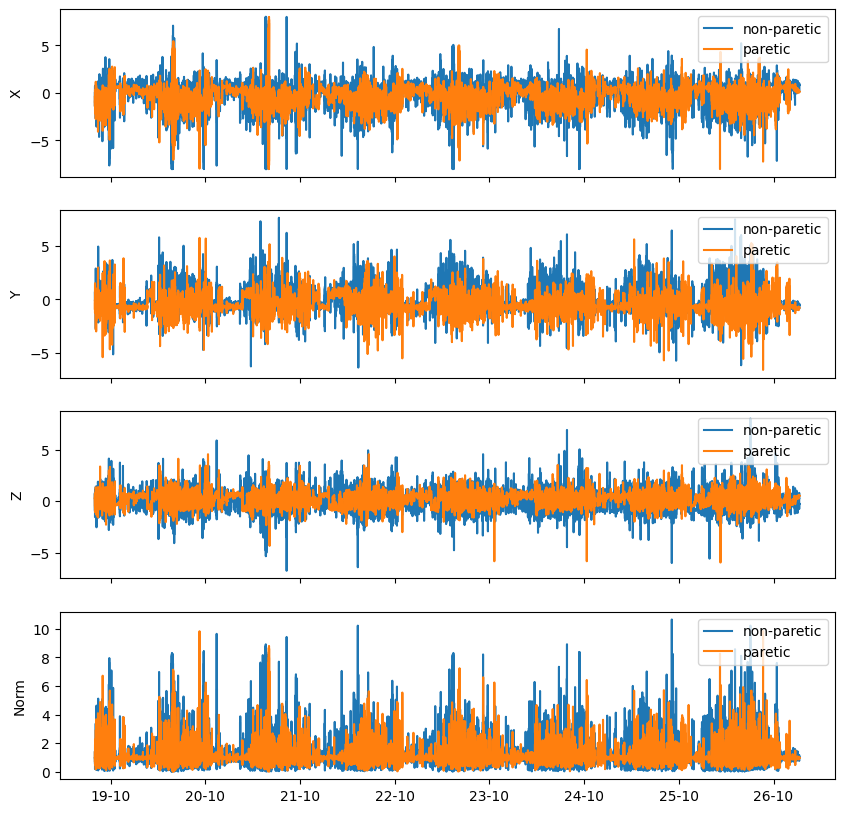

In [6]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(4):
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 0, i], label='non-paretic')
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 1, i], label='paretic')
    ax[i].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
    ax[i].legend(loc='upper right')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.show()

In [7]:
# low pass filter, 10 Hz (dusfour et al. uses 50 Hz but we don't have sufficient resolution)
from scipy.signal import butter, filtfilt

def low_pass_filter(time_series, delta_t, cutoff=10):
    """
    Apply a low-pass filter to a time series with a cutoff frequency of 50 Hz.

    Parameters:
        time_series (np.ndarray): The input time series data.
        delta_t (float): The time step between consecutive samples.
        cutoff (float): The cutoff frequency for the low-pass filter (default is 50 Hz).

    Returns:
        np.ndarray: The filtered time series.
    """
    # Calculate the Nyquist frequency
    nyquist = 0.5 / delta_t
    
    # Ensure cutoff frequency is below the Nyquist frequency
    if cutoff >= nyquist:
        raise ValueError("Cutoff frequency must be less than the Nyquist frequency.")
    
    # Design the Butterworth filter
    b, a = butter(N=4, Wn=cutoff / nyquist, btype='low', analog=False)
    
    # Apply the filter to the time series
    filtered_series = filtfilt(b, a, time_series)
    
    return filtered_series


filtered_values = np.zeros_like(space_values)
for i in range(space_values.shape[1]):
    for j in range(space_values.shape[2]):
        filtered_values[:, i, j] = low_pass_filter(space_values[:, i, j], delta_t)

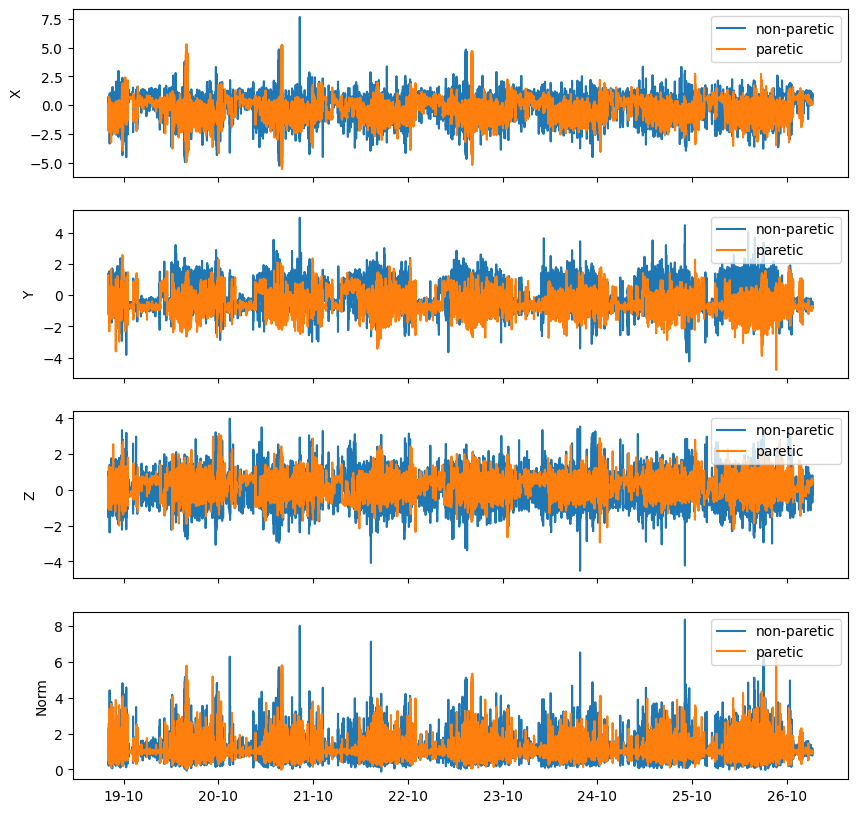

In [8]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(4):
    ax[i].plot(pd.to_datetime(time_index, unit='s'), filtered_values[:, 0, i], label='non-paretic')
    ax[i].plot(pd.to_datetime(time_index, unit='s'), filtered_values[:, 1, i], label='paretic')
    ax[i].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
    ax[i].legend(loc='upper right')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.show()

In [9]:
space_values = filtered_values

In [10]:
def partition(space_values, time_index, seconds_per_window=5):
    delta_t = float(np.diff(time_index).mean())

    number_timepoints = space_values.shape[0]
    number_arms = space_values.shape[1]
    number_axis= space_values.shape[2]

    # partition the data into windows
    window_size = int(seconds_per_window / delta_t)
    num_windows = number_timepoints // window_size

    print(f"delta_t: {delta_t}")
    print(f"window_size: {window_size}")
    print(f"num_windows: {num_windows}")

    space_values = space_values[:num_windows * window_size]
    space_values = space_values.reshape((num_windows, window_size, number_arms, number_axis))

    time_index = time_index[:num_windows * window_size]
    time_index = time_index.reshape((num_windows, window_size))
    
    return space_values, time_index

# Defining Functional Metrics

## Jerk

$J_i(t)=\frac{a_i(t+d t)-a_i(t-d t)}{2 d t}$

In [11]:
def get_jerk(space_values, time_index):
    delta_t = np.mean(time_index[2:] - time_index[:-2])
    jerk_xyz = (space_values[2:, :, 0:3] - space_values[:-2, :, 0:3]) / (2 * delta_t)
    jerk_norm = np.linalg.norm(jerk_xyz, axis=2)
    jerk_norm = jerk_norm.reshape(jerk_norm.shape[0], jerk_norm.shape[1], 1)

    return np.concatenate((jerk_xyz, jerk_norm), axis=2)

$\operatorname{Jerk}_{\text {Ratio }}=2 x \frac{\mid \text { Jerk }_{\text {paretic }} \mid}{\mid \text { Jerk }_{\text {pareetic }}|+| \text { Jerk }_{\text {non-paretic }}|}$

In [12]:
get_jerk_ratio = lambda jerk : 2 * np.abs(jerk[:, 1, 3]) / (np.abs(jerk[:, 0, 3]) + np.abs(jerk[:, 1, 3]))

## Functional Measures

### Alpha

$\alpha(t)=\operatorname{arcos}\left(\frac{a_y(t)}{E N(t)}\right)$

In [13]:
get_alphas = lambda a_y, EN : np.arccos(a_y / EN) - np.deg2rad(90)

### Functional Count

Functional: $|\alpha| \leq 30^{\circ} \text { and } \alpha_{\text {max }}-\alpha_{\text {min }} \geq 30^{\circ} $

In [14]:
test_functional = lambda alphas : (np.abs(alphas) <= np.deg2rad(30)).all(axis=1) & ((alphas.max(axis=1) - alphas.min(axis=1)) >= np.deg2rad(30))

### Use Hours

In [15]:
# The total hours of use is the total amount of time, in hours, as measured by summing the seconds when the activity count was > 0

def get_use_hours(is_functional, time_indexes):
    # get first element of each window
    start = time_indexes[:, 0]
    
    # get differences
    delta_t = np.diff(start).mean()
    
    # get the second when each window starts
    idx = delta_t * np.ones(start.shape[0])
    idx = np.cumsum(idx)
    idx = np.floor(idx).astype(int)

    # one row per second, one column per arm
    times_used = np.zeros((idx[-1] + 1, is_functional.shape[1]))
    
    for i in range(is_functional.shape[0]):
        for j in range(is_functional.shape[1]):
            times_used[idx[i], j] += is_functional[i, j]

    was_used = times_used > 0

    return was_used.sum(axis=0) / 3600

# Implementing

In [16]:
jerk = get_jerk(space_values, time_index)

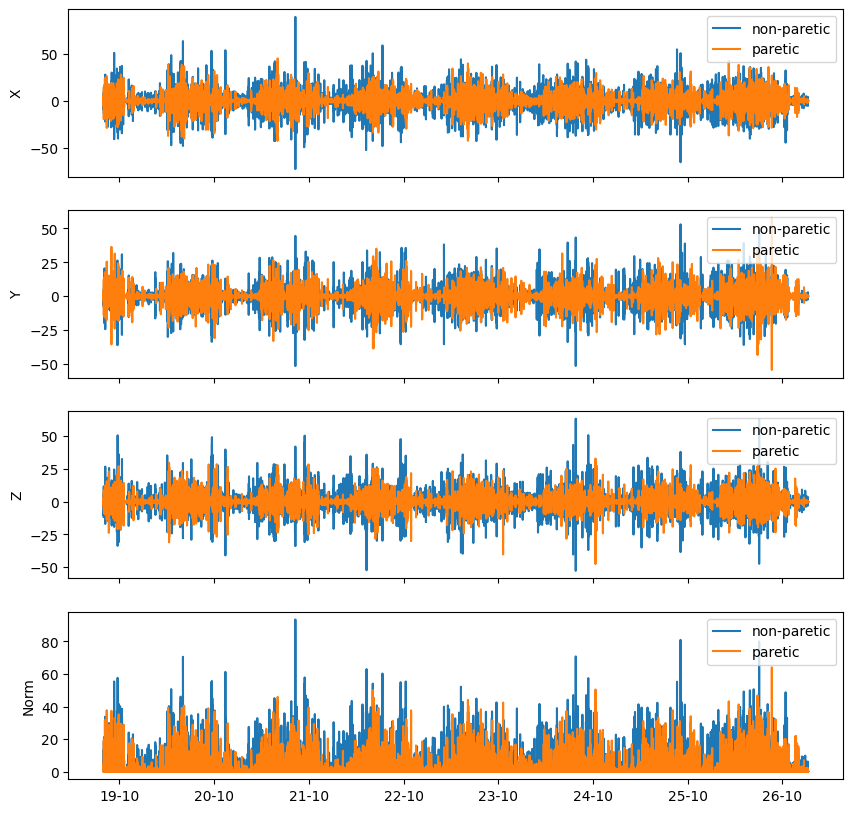

In [17]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(4):
    ax[i].plot(pd.to_datetime(time_index[1:-1], unit='s'), jerk[:, 0, i], label='non-paretic')
    ax[i].plot(pd.to_datetime(time_index[1:-1], unit='s'), jerk[:, 1, i], label='paretic')
    ax[i].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
    ax[i].legend(loc='upper right')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.show()

In [18]:
jerk_ratio = get_jerk_ratio(jerk)

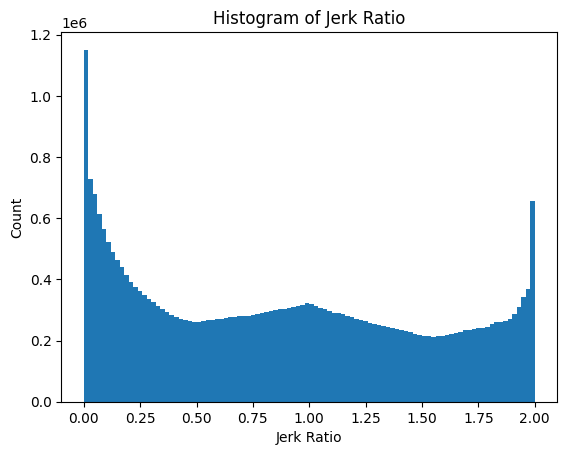

In [19]:
# histogram of jerk ratio
plt.hist(jerk_ratio, bins=100)
plt.title("Histogram of Jerk Ratio")
plt.xlabel("Jerk Ratio")
plt.ylabel("Count")

plt.show()

In [20]:
windows_small, time_indexes_small = partition(space_values, time_index, seconds_per_window=0.5)

delta_t: 0.020577736579621808
window_size: 24
num_windows: 1301590


In [21]:
alphas = get_alphas(windows_small[:, :, :, 1], windows_small[:, :, :, 3])

/var/folders/qn/sypqqw3101v1k6_70wqyd99h0000gn/T/ipykernel_14103/4019828861.py:1: RuntimeWarning: invalid value encountered in arccos
  get_alphas = lambda a_y, EN : np.arccos(a_y / EN) - np.deg2rad(90)


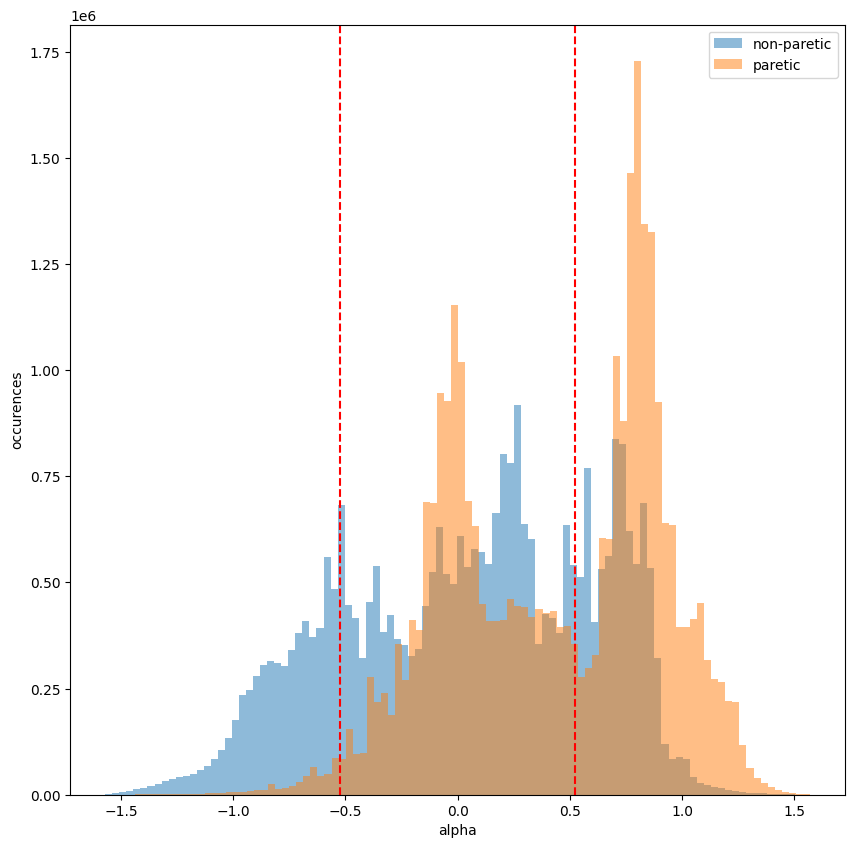

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)

ax.hist(alphas[:, :, 0].flatten(), bins=100, alpha=0.5, label='non-paretic')
ax.hist(alphas[:, :, 1].flatten(), bins=100, alpha=0.5, label='paretic')

# mark +- 30 degrees
ax.axvline(np.deg2rad(30), color='r', linestyle='--')
ax.axvline(-np.deg2rad(30), color='r', linestyle='--')

ax.set_xlabel('alpha')
ax.set_ylabel('occurences')
ax.legend(loc='upper right')

plt.show()

In [23]:
alpha = get_alphas(space_values[:, :, 1], space_values[:, :, 3])

/var/folders/qn/sypqqw3101v1k6_70wqyd99h0000gn/T/ipykernel_14103/4019828861.py:1: RuntimeWarning: invalid value encountered in arccos
  get_alphas = lambda a_y, EN : np.arccos(a_y / EN) - np.deg2rad(90)


In [24]:
is_functional = test_functional(alphas)

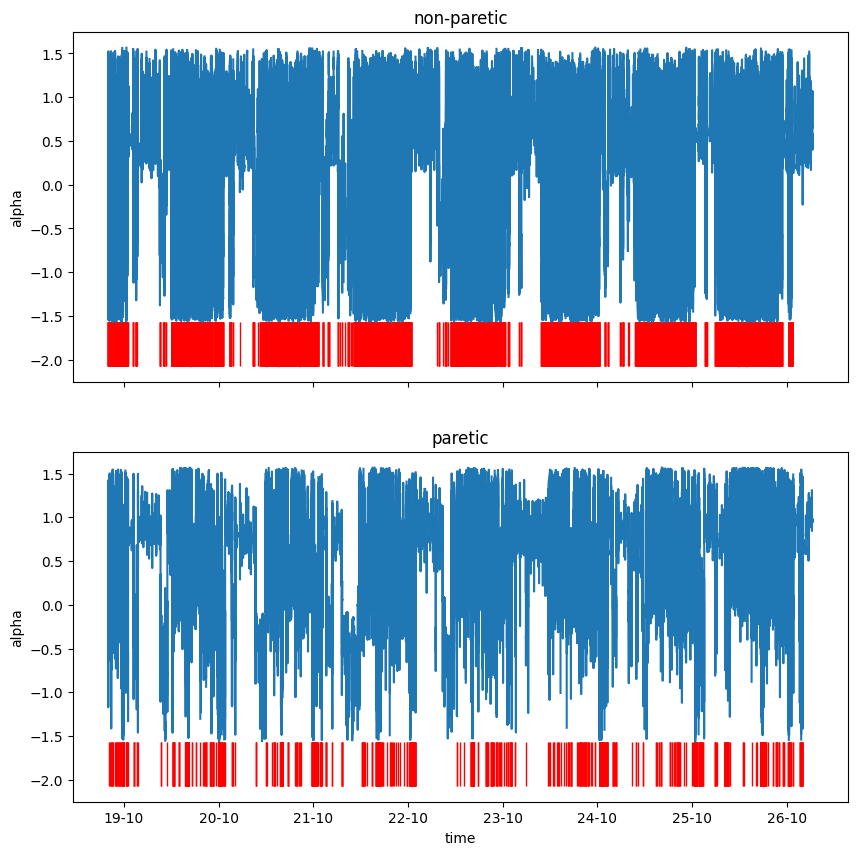

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

for i in range(2):
    ax[i].plot(pd.to_datetime(time_index, unit='s'), alpha[:, i])
    ax[i].set_title(['non-paretic', 'paretic'][i])

    for j in range(len(time_indexes_small)):
        if is_functional[j, i]:
            ax[i].fill_between(pd.to_datetime(time_indexes_small[j], unit='s'),  -np.deg2rad(90)-0.5, -np.deg2rad(90), color='red')

ax[1].set_xlabel('time')
ax[0].set_ylabel('alpha')
ax[1].set_ylabel('alpha')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))



In [26]:
get_use_hours(is_functional, time_indexes_small)

array([2.44694444, 0.47194444])

# Entropies

In [27]:
windows_big, time_indexes_big = partition(space_values, time_index, seconds_per_window=5)

delta_t: 0.020577736579621808
window_size: 242
num_windows: 129083


In [28]:
windows_big.shape

(129083, 242, 2, 4)

In [41]:
import EntropyHub as EH

Aps = np.zeros((windows_big.shape[0], windows_big.shape[2]))
for num_window in range(windows_big.shape[0]):
    for arm in range(windows_big.shape[2]):
        Sig = windows_big[num_window, :, arm, 3] # Norm
        Samp = EH.SampEn(Sig, tau=1, m=2)

        print(Samp)

        print(f"arm: {arm}, num_window: {num_window}, Ap: {Samp[-1]}")
        
        Aps[num_window, arm] = Samp[-1]

(array([1.86587008, 1.2068004 , 0.69239952]), array([4513., 1342.,  669.]), array([29161.,  4486.,  1337.]))
arm: 0, num_window: 0, Ap: [29161.  4486.  1337.]


ValueError: setting an array element with a sequence.

In [31]:
start = time_indexes_big[:, 0]

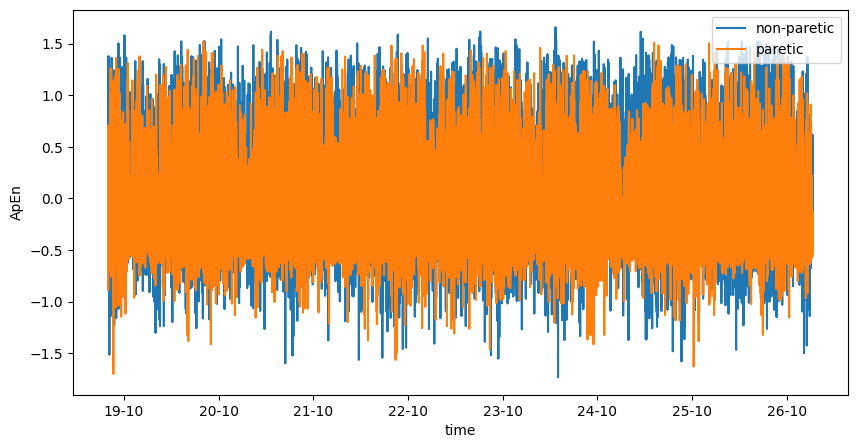

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

for i in range(2):
    ax.plot(pd.to_datetime(start, unit='s'), Aps[:, i], label=['non-paretic', 'paretic'][i])
    ax.legend(loc='upper right')

ax.set_xlabel('time')
ax.set_ylabel('ApEn')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))